<a href="https://colab.research.google.com/github/6X10/Projects/blob/main/Advanced%20Statistical%20Data%20Analysis%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term project code

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing # https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score # https://scikit-learn.org/stable/modules/model_evaluation.html

from sklearn.linear_model import LogisticRegression # https://scikit-learn.org/stable/modules/linear_model.html
from sklearn.naive_bayes import GaussianNB # https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [ ]:
#Importing data
path="C:/Users/양현주/K/"
loan=pd.read_csv(path+"loan.csv", dtype=object)
print(loan.shape)

(39717, 111)


## 1. 주제 및 자료 선정 배경

대출 여부에는 다양한 요소들이 고려되지만, 사실 이 모든 요소들이 궁극적으로 측정하고자 하는 것은 빌린 사람이 돈을 갚을 사람인가이다. 이는 빌린 사람이 돈을 갚는다면 빌려준 사람 혹은 회사가 이익을 얻지만, 반대라면 손해를 입기 때문이다. 이번 분석은 정보를 넣으면, 이 사람이 돈을 갚을 사람인지 아닌지를 예측하는 모델을 만드는 것이다.

- 데이터 : Loan dataset (https://www.kaggle.com/datasets/abhishek14398/loan-dataset)

- 실제로  분석에 사용되는 변수 설명:
    - loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
    - term: The number of payments on the loan. Values are in months and can be either 36 or 60.
    - int_rate: Interest Rate on the loan
    - sub_grade: LC assigned loan subgrade
    - emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
    - home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
    - annual_inc: The self-reported annual income provided by the borrower during registration
    - verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
    - loan_status: Current status of the loan
    - purpose: A category provided by the borrower for the loan request.
    - zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application.
    - addr_state: The state provided by the borrower in the loan application
    - dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
    - delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
    - inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
    - open_acc: The number of open credit lines in the borrower's credit file.
    - pub_rec: Number of derogatory public records
    - revol_bal: Total credit revolving balance
    - revo_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
    - total_acc: The total number of credit lines currently in the borrower's credit file
    - out_prncp: Remaining outstanding principal for total amount funded
    - out_prncp_inv: Remaining outstanding principal for portion of total amount funded by investors
    - total_pymnt: Payments received to date for total amount funded
    - total_rec_prncp: Principal received to date
    - total_rec_int: Interest received to date
    - total_rec_late_fee: Late fees received to date
    - recoveries: post charge off gross recovery
    - collection_recovery_fee: post charge off collection fee
    - last_pymnt_amnt: Last total payment amount received
    - pub_rec_bankruptcies: Number of public record bankruptcies

## 2. EDA

### 2.1. 불필요한 행 제거

- 이 데이터의 경우 모든 행이 NA인 변수도 많고, 비슷한 것을 measure하는 변수도 많다. 이외에도 예측하는 상황에서 예측하기 어려운 변수들도 존재하기 때문에, 모든 column을 feature로 사용하는 것은 예측을 더 어렵게 만들 뿐이다. 따라서 조건을 만족하는 행을 제거하고자 한다.

-	불필요한 행 제거 \
    Id, member id, url는 분석에 불필요하고, grade는 sub_grade와 연관이 깊으며, date 관련 데이터는 대출심사에 크리티컬하게 작용하는 요소가 아니라고 생각해 전체 데이터셋에서 제거했다


In [ ]:
#Eliminate id & redundant features
loan.drop(['id', 'member_id','grade',"url", "issue_d", "earliest_cr_line", "next_pymnt_d","last_pymnt_d","last_credit_pull_d"],inplace=True, axis=1)

In [ ]:
#Eliminate columns having all values as null
print(pd.isnull(loan).all(axis=0).sum())
loan.drop(loan.columns[loan.isnull().all(axis=0)],inplace=True,axis=1)
print(pd.isnull(loan).all(axis=0).sum())

54
0


In [ ]:
#Eliminate columns having more than 12000(about 30%) of values as null
loan.drop(loan.columns[pd.isnull(loan).sum(axis=0)>12000],inplace=True, axis=1)

In [ ]:
#Eliminatecolumns having only one levels
loan.describe().loc["unique"]
loan.drop(loan.columns[loan.describe().loc["unique"]==1],inplace=True, axis=1)

In [ ]:
#convert to continous after drop %
loan['int_rate']=loan['int_rate'].str.rstrip('%')
loan['revol_util']=loan['revol_util'].str.rstrip('%')
continuous = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "annual_inc", "dti", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_amnt"]
loan[continuous]=loan[continuous].apply(pd.to_numeric)

In [ ]:
#Eliminate columns having so many levels in categorical variable with missing
categorical=list(set(loan.columns)-set(continuous))
print(loan[categorical].describe().loc["unique"])
print(pd.isnull(loan[loan[categorical].columns[loan[categorical].describe().loc["unique"]>50]]).sum(axis=0))
loan.drop(["emp_title", "title"],inplace=True, axis=1)

purpose                    14
emp_title               28820
sub_grade                  35
pub_rec_bankruptcies        3
addr_state                 50
zip_code                  823
emp_length                 11
title                   19615
verification_status         3
term                        2
loan_status                 3
delinq_2yrs                11
home_ownership              5
Name: unique, dtype: object
emp_title    2459
zip_code        0
title          11
dtype: int64


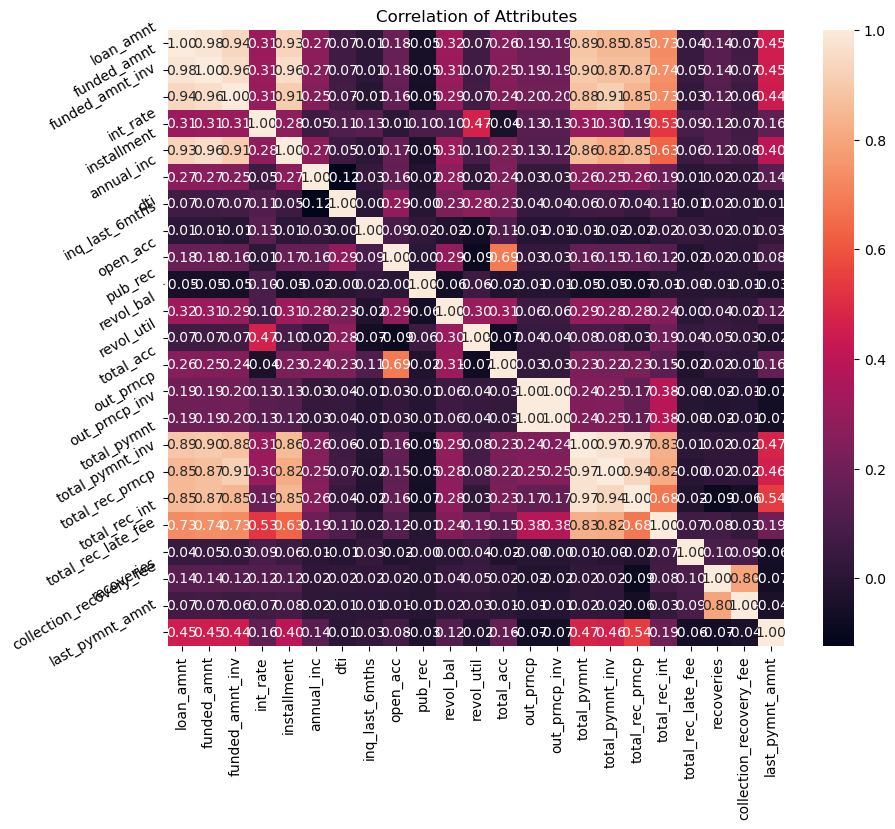

In [ ]:
#Eliminate similar variables(high correlation 0.9 이상). 이자에 대한 지불과 원금에 대한 지불이 다르기 때문에 둘은 correlation이 높지만 남겨뒀다.
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes')
a = sns.heatmap(loan.corr(), square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

high_corr = ["funded_amnt", "funded_amnt_inv", "installment", "total_pymnt_inv"]
loan.drop(high_corr,inplace=True, axis=1)

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   term                     39717 non-null  object 
 2   int_rate                 39717 non-null  float64
 3   sub_grade                39717 non-null  object 
 4   emp_length               38642 non-null  object 
 5   home_ownership           39717 non-null  object 
 6   annual_inc               39717 non-null  float64
 7   verification_status      39717 non-null  object 
 8   loan_status              39717 non-null  object 
 9   purpose                  39717 non-null  object 
 10  zip_code                 39717 non-null  object 
 11  addr_state               39717 non-null  object 
 12  dti                      39717 non-null  float64
 13  delinq_2yrs              39717 non-null  object 
 14  inq_last_6mths        

### 2.2. Statistical Summaries & Visualization

In [ ]:
#continous variables
print(loan.describe())

          loan_amnt      int_rate    annual_inc           dti  inq_last_6mths  \
count  39717.000000  39717.000000  3.971700e+04  39717.000000    39717.000000   
mean   11219.443815     12.021177  6.896893e+04     13.315130        0.869200   
std     7456.670694      3.724825  6.379377e+04      6.678594        1.070219   
min      500.000000      5.420000  4.000000e+03      0.000000        0.000000   
25%     5500.000000      9.250000  4.040400e+04      8.170000        0.000000   
50%    10000.000000     11.860000  5.900000e+04     13.400000        1.000000   
75%    15000.000000     14.590000  8.230000e+04     18.600000        1.000000   
max    35000.000000     24.590000  6.000000e+06     29.990000        8.000000   

           open_acc       pub_rec      revol_bal    revol_util     total_acc  \
count  39717.000000  39717.000000   39717.000000  39667.000000  39717.000000   
mean       9.294408      0.055065   13382.528086     48.832152     22.088828   
std        4.400282      0.237

In [ ]:
#categorical variables
categorical_columns = [x for x in loan.dtypes.index if loan[x].dtypes=='object']
for col in categorical_columns:
    print('\nFrequency of Categories for variable %s'%col)
    print(loan[col].value_counts())


Frequency of Categories for variable term
 36 months    29096
 60 months    10621
Name: term, dtype: int64

Frequency of Categories for variable sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: sub_grade, dtype: int64

Frequency of Categories for variable emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

Frequency of Categories for variable home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: ho

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

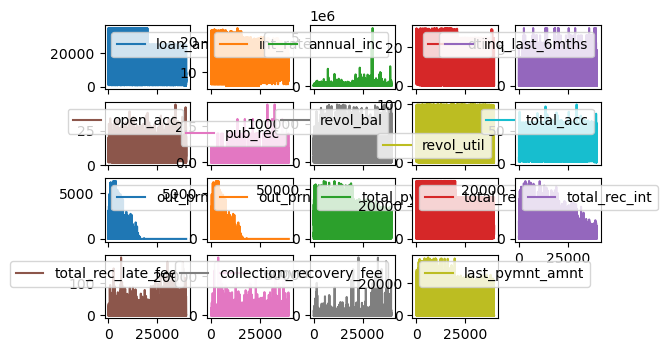

In [ ]:
#distribution
loan.plot(subplots=True, layout=(5,5))

row-wise eliminating

### 2.3. Pre-processing

In [ ]:
# Dropping the current customers as they are not required for driving factors consideration.
loan = loan[loan.loan_status != "Current"]
loan.shape

(38577, 30)

#### 2.3.1 missing value

In [ ]:
# Eliminating rows containing either 50% or more than 50% NaN Values
threshold = int(((100-50)/100)*loan.shape[1] + 1) # the number of objects
loan.dropna(thresh=threshold)
loan = loan.reset_index(drop=True)
loan.shape

(38577, 30)

- Data split to train & test

In [ ]:
Y=loan.pop("loan_status")
X=loan

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,shuffle=True, test_size=0.3, random_state=1982037)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(27003, 29)
(27003,)
(11574, 29)
(11574,)


- Missing value Imputation

In [ ]:
#Find missing values
print(X_train.isna().sum()!=0)
X_train['emp_length'].fillna(X_train['emp_length'].mode()[0], inplace=True)
X_train['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_train['pub_rec_bankruptcies'].fillna(X_train['pub_rec_bankruptcies'].mode()[0], inplace=True)

print(X_test.isna().sum()!=0)
X_test['emp_length'].fillna(X_train['emp_length'].mode()[0], inplace=True)
X_test['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_test['pub_rec_bankruptcies'].fillna(X_train['pub_rec_bankruptcies'].mode()[0], inplace=True)

loan_amnt                  False
term                       False
int_rate                   False
sub_grade                  False
emp_length                  True
home_ownership             False
annual_inc                 False
verification_status        False
purpose                    False
zip_code                   False
addr_state                 False
dti                        False
delinq_2yrs                False
inq_last_6mths             False
open_acc                   False
pub_rec                    False
revol_bal                  False
revol_util                  True
total_acc                  False
out_prncp                  False
out_prncp_inv              False
total_pymnt                False
total_rec_prncp            False
total_rec_int              False
total_rec_late_fee         False
recoveries                 False
collection_recovery_fee    False
last_pymnt_amnt            False
pub_rec_bankruptcies        True
dtype: bool
loan_amnt                  Fals

In [ ]:
print('\nResult after imputation of train data')
print(X_train.info())
print('\nResult after imputation of test data')
print(X_test.info())


Result after imputation of train data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27003 entries, 3683 to 29012
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                27003 non-null  int64  
 1   term                     27003 non-null  object 
 2   int_rate                 27003 non-null  float64
 3   sub_grade                27003 non-null  object 
 4   emp_length               27003 non-null  object 
 5   home_ownership           27003 non-null  object 
 6   annual_inc               27003 non-null  float64
 7   verification_status      27003 non-null  object 
 8   purpose                  27003 non-null  object 
 9   zip_code                 27003 non-null  object 
 10  addr_state               27003 non-null  object 
 11  dti                      27003 non-null  float64
 12  delinq_2yrs              27003 non-null  object 
 13  inq_last_6mths           27003 non

#### 2.3.2 data transformation

In [ ]:
#Convert categorical variable into dummy variables
#Normalization to rescale continuous variables into the range [0,1] to match the range of categorical variables : x' = (x – min) / (max – min)

def data_transform(df):
    numericalcols=list(df.select_dtypes(exclude='object').columns)
    data=pd.get_dummies(df)
    scaler = MinMaxScaler()
    data[numericalcols]=scaler.fit_transform(data[numericalcols])

    return data

total = data_transform(pd.concat([X_train, X_test]))
total = total.reset_index(drop=True)

X_train=total.loc[0:(len(X_train)-1),:]
X_test=total.loc[len(X_train):,: ]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(27003, 975) (27003,)
(11574, 975) (11574,)


## Modeling & Evaluation

- Target 변수인 loan_status는 Fully Paid-32950개, Charged Off-5627개인 unbalanced data이다.  따라서 accuracy만으로 모델 간 성능을 비교하기는 어렵기 때문에 accuracy score 외에도 precision score, recall score를 이용해서 fully paid로 쏠릴 수 있는 한계를 보완하고자 한다. Hyperparameter tuning을 할 때도 마찬가지로 unbalanced data를 고려할 수 있는 roc_auc score를 사용하고자 한다.
- 더하여 예측의 결과가 확률과 함께 나오게 하는 것은 신뢰도를 높이는데, 금융 데이터의 특성상 신뢰도가 매우 중요하기 때문에 이를 위해서 확률 기반의 두 model을 사용하였다.


### 3.1. Logistic Regression

로지스틱 회귀분석은 신용 카드 회사에서 고객이 지불을 불이행할 가능성을 예측하는 등 이미 이 분석과 비슷한 목적의 분석에서 널리 쓰이고 있기 때문에 어느 정도 성능을 보장한 비교를 위한 베이스 모형이 될 수 있다.

In [ ]:
#hyper paramter tuning process
modelLOGIT=LogisticRegression(solver="saga", max_iter=1000)

#candidate for hyper parameter
hyper_LOGIT = {'penalty': ['l1','l2'], "C" : [0.01,0.1,1,10,100]}

#hyper paramter tuning by 5-fold cross validation(check all candidates)
gs_LOGIT=RandomizedSearchCV(estimator=modelLOGIT, param_distributions=hyper_LOGIT, scoring='roc_auc', n_jobs=2, verbose=3)
gs_LOGIT.fit(X_train, Y_train)
print(gs_LOGIT.best_score_)
print(gs_LOGIT.best_estimator_) #optimal hyper parameter

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
repeat=3
testingAccuracy_LOGIT = np.zeros((repeat, 3))
for rep in range(repeat):
    sample=np.random.permutation(np.arange(X_train.shape[0]))
    X=X_train.iloc[sample,:]
    Y=Y_train.iloc[sample]

    LOGIT=LogisticRegression(C=1, penalty="l1", max_iter=1000, solver="saga") #GaussianNB model with optimal hyper parameter
    LOGIT.fit(X,Y)

    Y_test_pred_LOGIT = LOGIT.predict(X_test) #Perform classification on test data

    #accuracy score
    testingAccuracy_LOGIT[rep,0]=accuracy_score(Y_test, Y_test_pred_LOGIT)
    #precision score
    testingAccuracy_LOGIT[rep,1]=precision_score(Y_test, Y_test_pred_LOGIT, pos_label="Fully Paid")
    #recall score
    testingAccuracy_LOGIT[rep,2]=recall_score(Y_test, Y_test_pred_LOGIT, pos_label='Fully Paid')


C:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
#average accuracy score & std accuracy score
LOGIT_avg_accuracy=np.mean(testingAccuracy_LOGIT[:,0])
LOGIT_std_accuracy=np.std(testingAccuracy_LOGIT[:,0])
#average precision score & std precision score
LOGIT_avg_precision=np.mean(testingAccuracy_LOGIT[:,1])
LOGIT_std_precision=np.std(testingAccuracy_LOGIT[:,1])
#average recall score & std recall score
LOGIT_avg_recall=np.mean(testingAccuracy_LOGIT[:,2])
LOGIT_std_recall=np.std(testingAccuracy_LOGIT[:,2])

In [ ]:
#LOGIT Result with test data
print('\nAverage of accuracy score : %s'%LOGIT_avg_accuracy)
print('\nStandard deviation of accuracy score : %s'%LOGIT_std_accuracy)
print('\nAverage of precision score : %s'%LOGIT_avg_precision)
print('\nStandard deviation of precision score : %s'%LOGIT_std_precision)
print('\nAverage of recall score : %s'%LOGIT_avg_recall)
print('\nStandard deviation of recall score : %s'%LOGIT_std_recall)


Average of accuracy score : 0.9742526352168653

Standard deviation of accuracy score : 0.0

Average of precision score : 0.9762614223281685

Standard deviation of precision score : 0.0

Average of recall score : 0.9940331715210357

Standard deviation of recall score : 0.0


### 3.2. Naive Bayes Classifier

NBC는 feautre가 많기 때문에, 우도의 복잡도를 줄이는 장점이 있는 Naive Bayes Classfier를 모델로 선택했다. 다만 Gauss 분포를 가정함으로써 분포 평균에 가까운 표본에 더 많은 가중치를 부여하게 되므로, 이러한 단점을 상쇄하고자 분포 평균에서 더 멀리 떨어진 더 많은 표본들을 설명할 수 있도록 optimal 'var_smoothing' 값을 찾기 위한 hyper parameter tuning을 수행했다.

In [ ]:
#hyper paramter tuning process
ModelNB=GaussianNB() #Model: Gaussian Naive Bayes (b/c there are a lot of data, we can assume all the continous variables to be distributed according to Gaussian Distribution.)

#candidate for hyper parameter
hyper_NB = {'var_smoothing': np.logspace(1,-9, num=100)} #Portion of the largest variance of all features that is added to variances for calculation stability.

#hyper paramter tuning by 5-fold cross validation(check all candidates)
gs_NB=RandomizedSearchCV(estimator=ModelNB, param_distributions=hyper_NB, scoring='roc_auc', n_jobs=2, verbose=3)
gs_NB.fit(X_train, Y_train)
print(gs_NB.best_score_)
print(gs_NB.best_estimator_) #optimal hyper parameter

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7618472564392005
GaussianNB(var_smoothing=0.6135907273413173)


In [ ]:
repeat=3
testingAccuracy_NB = np.zeros((repeat, 3))
for rep in range(repeat):
    sample=np.random.permutation(np.arange(X_train.shape[0]))
    X=X_train.iloc[sample,:]
    Y=Y_train.iloc[sample]

    NBC=GaussianNB(var_smoothing=0.6135907273413173) #GaussianNB model with optimal hyper parameter
    NBC.fit(X,Y)

    Y_test_pred_NB = NBC.predict(X_test) #Perform classification on test data

    #accuracy score
    testingAccuracy_NB[rep,0]=accuracy_score(Y_test, Y_test_pred_NB)
    #precision score
    testingAccuracy_NB[rep,1]=precision_score(Y_test, Y_test_pred_NB, pos_label="Fully Paid")
    #recall score
    testingAccuracy_NB[rep,2]=recall_score(Y_test, Y_test_pred_NB, pos_label='Fully Paid')

In [ ]:
#average accuracy score & std accuracy score
NB_avg_accuracy=np.mean(testingAccuracy_NB[:,0])
NB_std_accuracy=np.std(testingAccuracy_NB[:,0])
#average precision score & std precision score
NB_avg_precision=np.mean(testingAccuracy_NB[:,1])
NB_std_precision=np.std(testingAccuracy_NB[:,1])
#average recall score & std recall score
NB_avg_recall=np.mean(testingAccuracy_NB[:,2])
NB_std_recall=np.std(testingAccuracy_NB[:,2])

In [ ]:
#NB Result with test data
print('\nAverage of accuracy score : %s'%NB_avg_accuracy)
print('\nStandard deviation of accuracy score : %s'%NB_std_accuracy)
print('\nAverage of precision score : %s'%NB_avg_precision)
print('\nStandard deviation of precision score : %s'%NB_std_precision)
print('\nAverage of recall score : %s'%NB_avg_recall)
print('\nStandard deviation of recall score : %s'%NB_std_recall)


Average of accuracy score : 0.864696734059098

Standard deviation of accuracy score : 0.0

Average of precision score : 0.8669312169312168

Standard deviation of precision score : 1.1102230246251565e-16

Average of recall score : 0.9942354368932039

Standard deviation of recall score : 0.0


### 3.3. Performance Reporting

## 4. Additional Analysis
전반적으로 logistic regression의 성능이 NBC의 성능보다 압도적으로 좋다. 특히 logsitic regression은 accuracy, precision, recall 모든 곳에서 거의 100%에 수렴하는 것으로 보이는데, 이를 통해서 현재 업계에서 사용되는 방법론을 뛰어넘을 다른 머신러닝 방법론은 아직까지 없어보인다고 판단할 수 있다. 뿐만 아니라 양쪽의 score가 모두 좋아 unbalanced data를 사용한 예측모형의 단점까지도 잘 보완한 것 같다.

## 참고문헌
 - https://www.kaggle.com/code/abhishek14398/lending-club-case-study
 - https://www.kaggle.com/code/abdulhaq786/85-accuracy-using-random-forest-svm-and-knn
 - http://theprofessionalspoint.blogspot.com/2019/04/how-to-print-frequency-table-for-all.html
 - https://fairmlbook.org/code/adult.html
 - https://www.kaggle.com/code/khaledatef1/naive-bayes-classification
 - https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html
 - https://stackoverflow.com/questions/39828535/how-to-tune-gaussiannb
 - https://stackoverflow.com/questions/19018333/gridsearchcv-on-logisticregression-in-scikit-learn